In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("features_DEMO.csv")
targets = pd.read_csv("train.csv")
target = targets["toxic"]
target.describe()

,toxic
count,159571.000000
mean,0.095844
std,0.294379
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


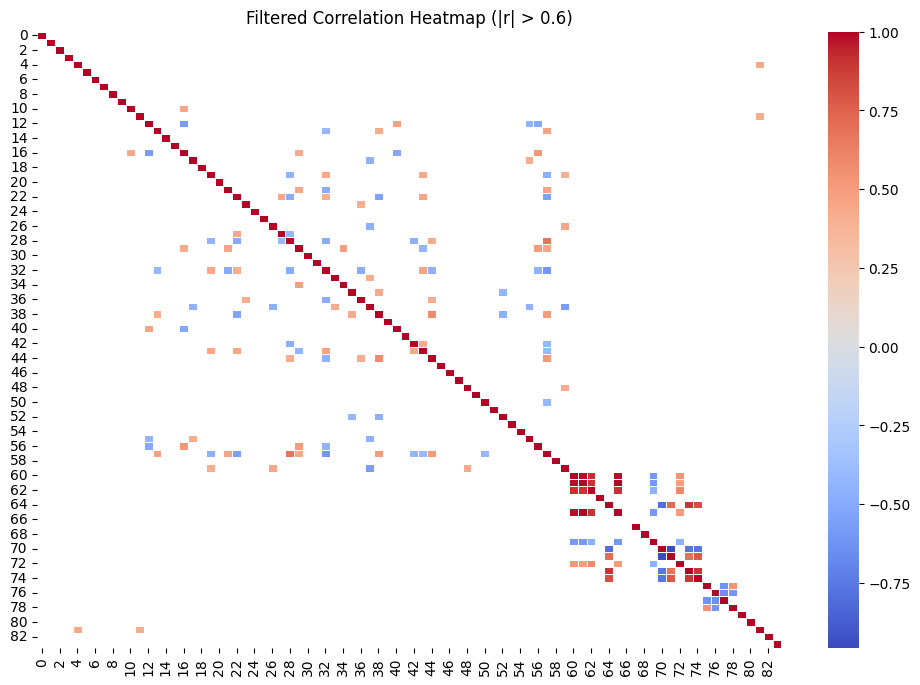

In [16]:

corr_matrix = data.corr()

# Apply threshold (only keep correlations above 0.6 or below -0.6)
mask = np.abs(corr_matrix) < 0.4
filtered_corr = corr_matrix.where(~mask, np.nan)

plt.figure(figsize=(12, 8))
sns.heatmap(filtered_corr, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Filtered Correlation Heatmap (|r| > 0.6)")
plt.show()


In [17]:
# test gfeatures for normality
from scipy.stats import shapiro

for i, feature in enumerate(data.columns):
  stat, p = shapiro(data[feature])
  if float(p) > 0.05:
      print(f"Feature {i} is normally distributed")
  else:
      print(f"Feature {i} is NOT normally distributed. P={float(p)}")

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 159571.
  res = hypotest_fun_out(*samples, **kwds)


Feature 0 is NOT normally distributed. P=2.7133184744337e-169
Feature 1 is NOT normally distributed. P=2.2785681096285445e-180
Feature 2 is NOT normally distributed. P=1.481412541292259e-179
Feature 3 is NOT normally distributed. P=2.7956363211784656e-179
Feature 4 is NOT normally distributed. P=1.8901633229472886e-172
Feature 5 is NOT normally distributed. P=1.0348873784253976e-178
Feature 6 is NOT normally distributed. P=4.017790796196777e-182
Feature 7 is NOT normally distributed. P=5.595276372014984e-178
Feature 8 is NOT normally distributed. P=1.1650290481687489e-178
Feature 9 is NOT normally distributed. P=2.05315956279969e-179
Feature 10 is NOT normally distributed. P=9.989383206138701e-68
Feature 11 is NOT normally distributed. P=7.447832315620008e-99
Feature 12 is NOT normally distributed. P=2.0773764996674793e-93
Feature 13 is NOT normally distributed. P=3.0595416911462434e-84
Feature 14 is NOT normally distributed. P=5.870315126938825e-88
Feature 15 is NOT normally distribut

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-le

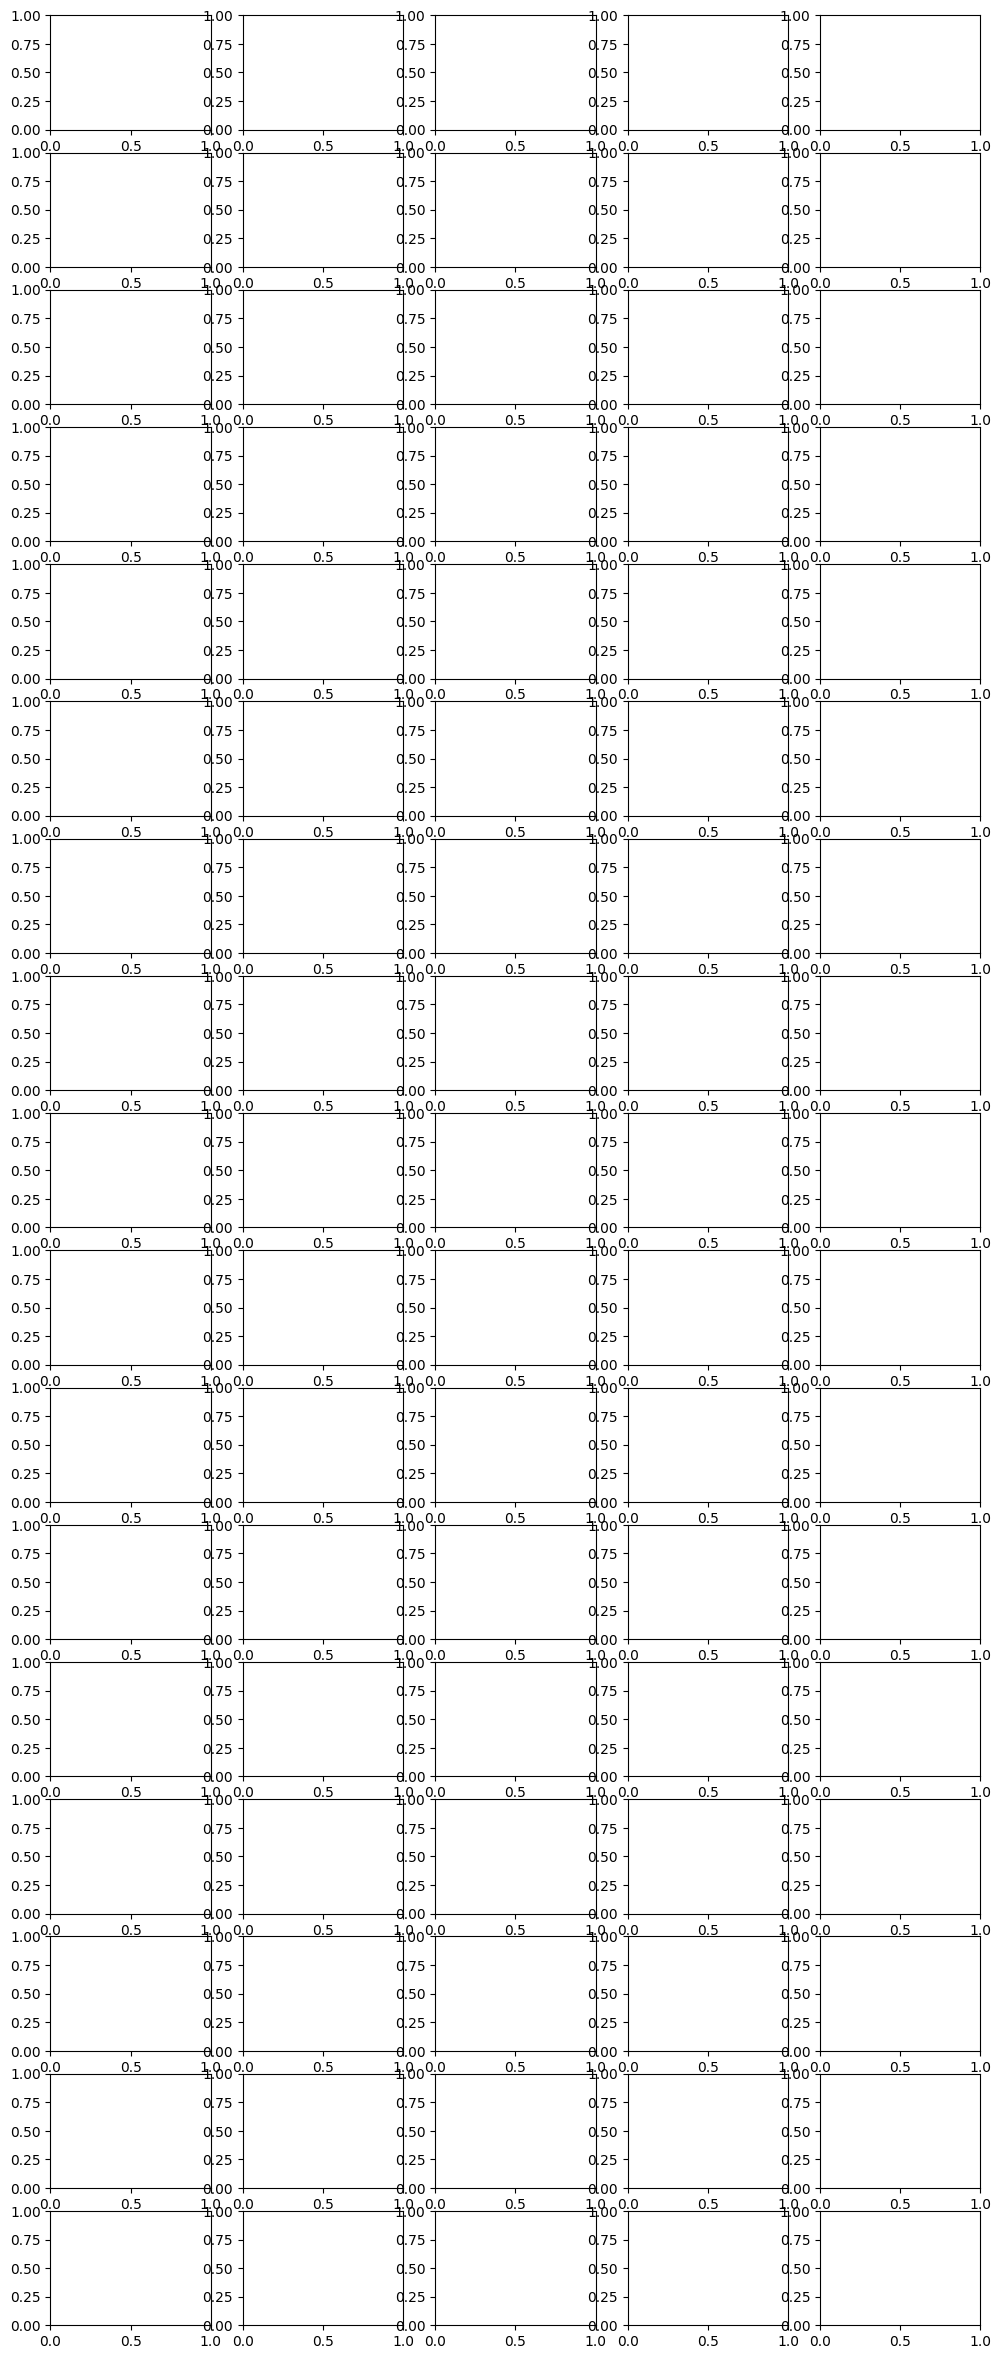

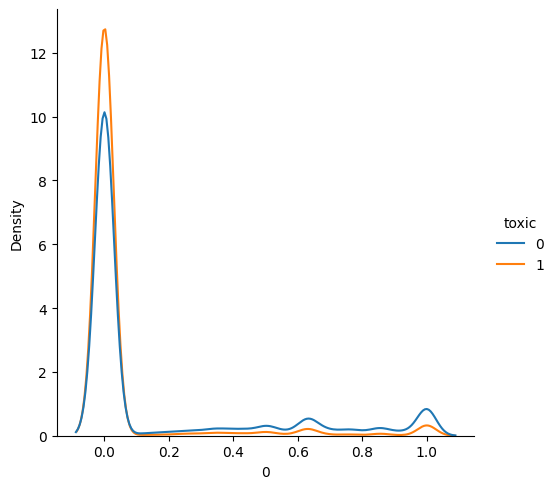

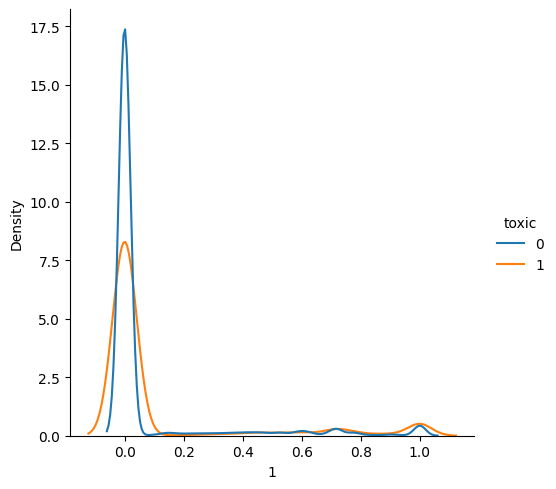

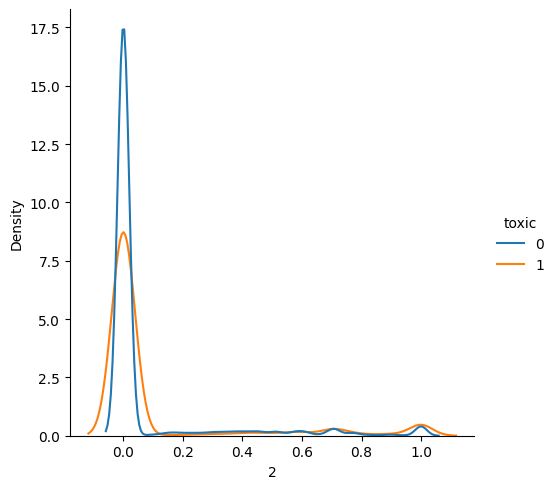

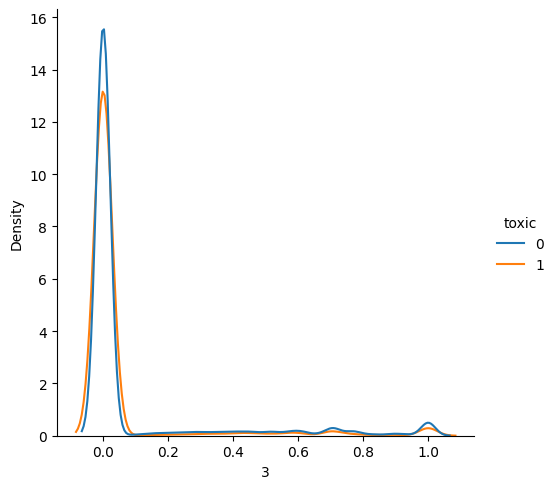

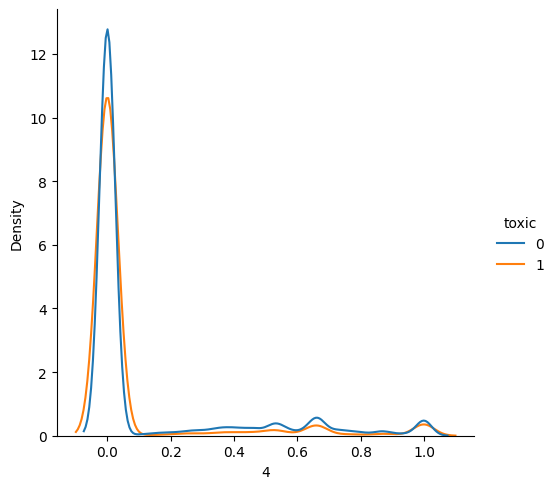

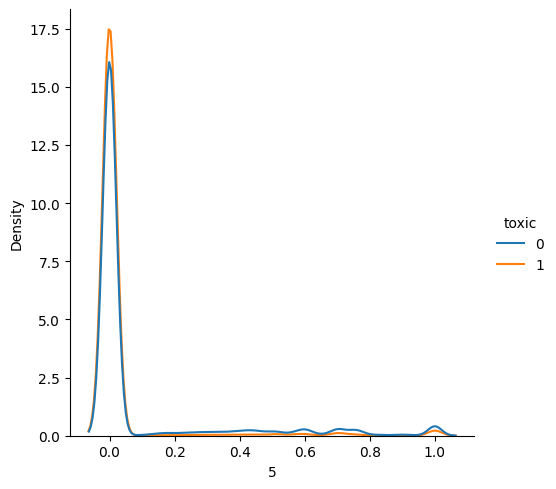

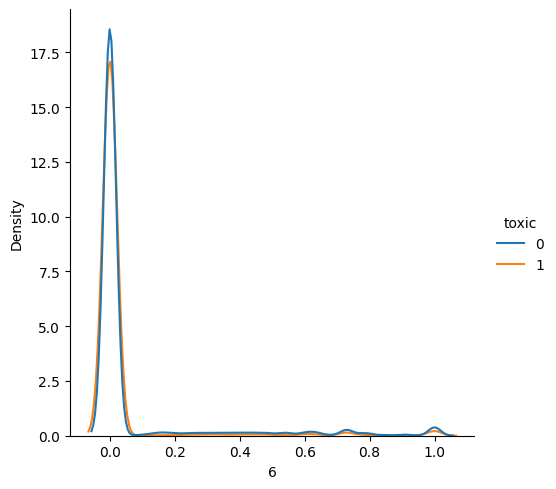

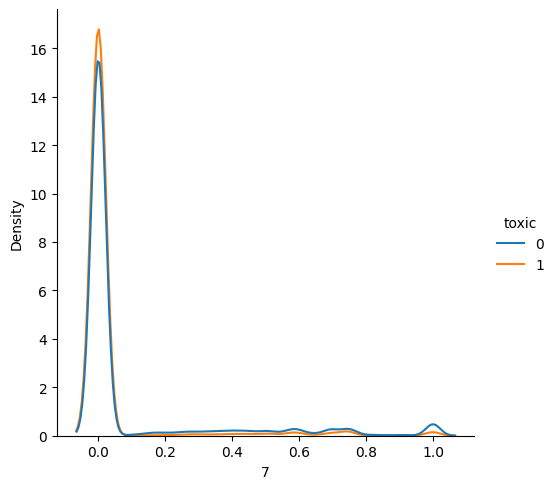

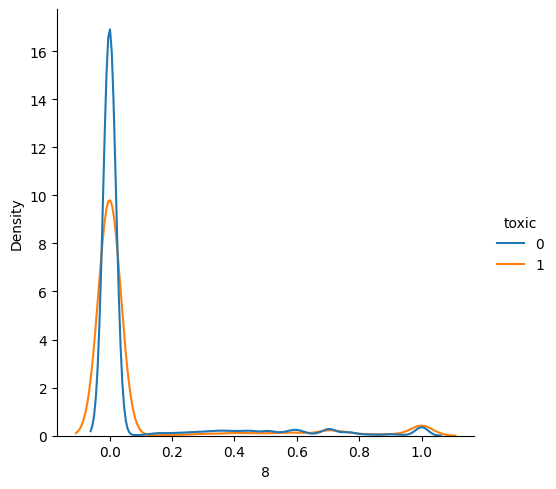

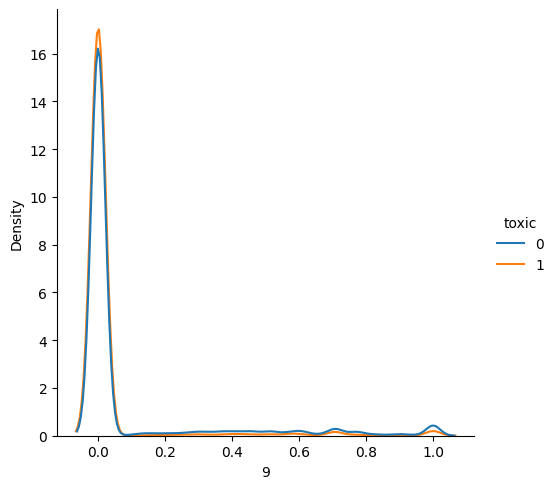

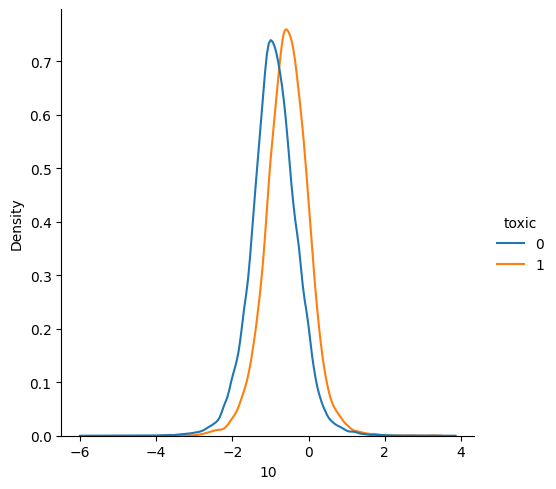

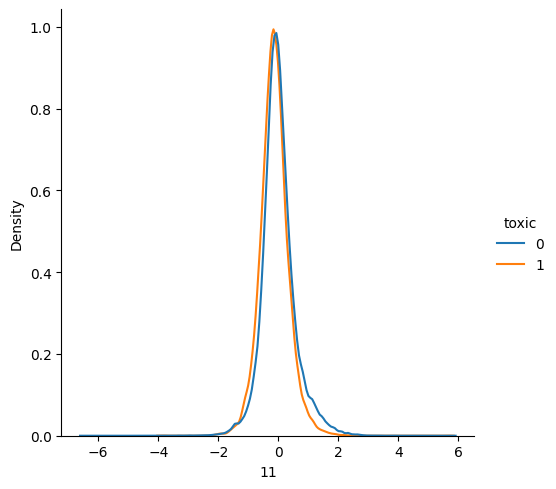

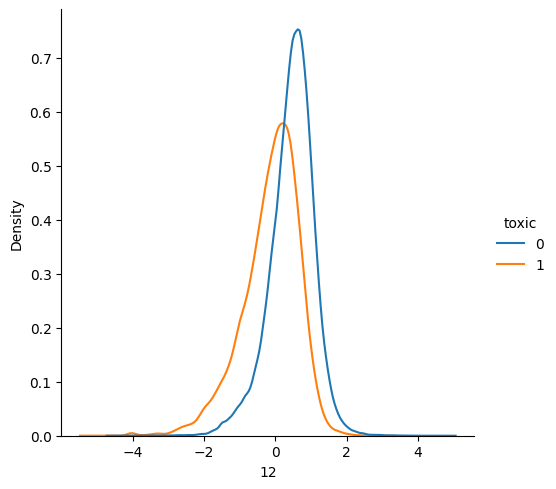

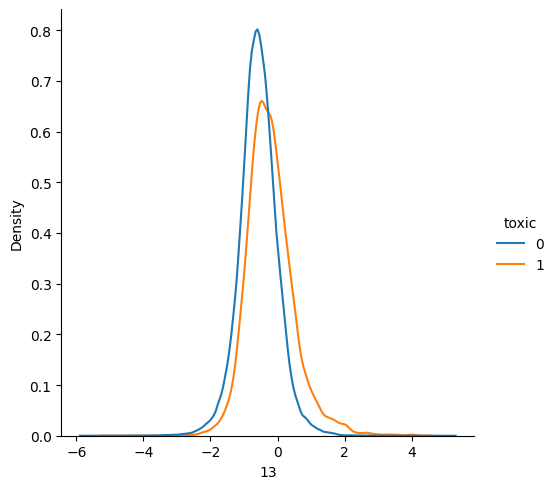

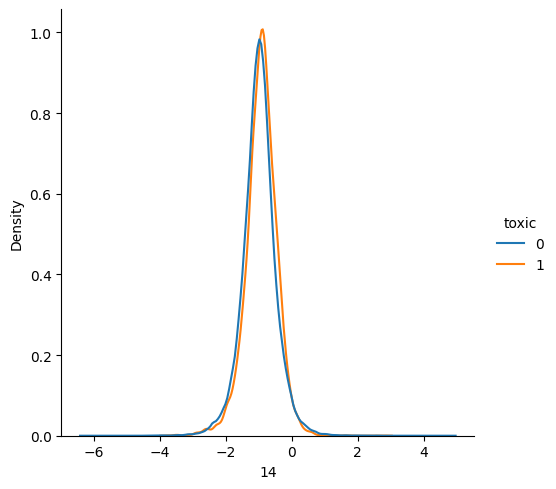

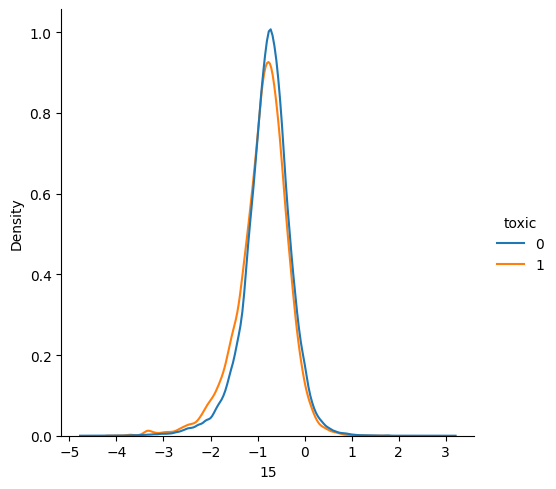

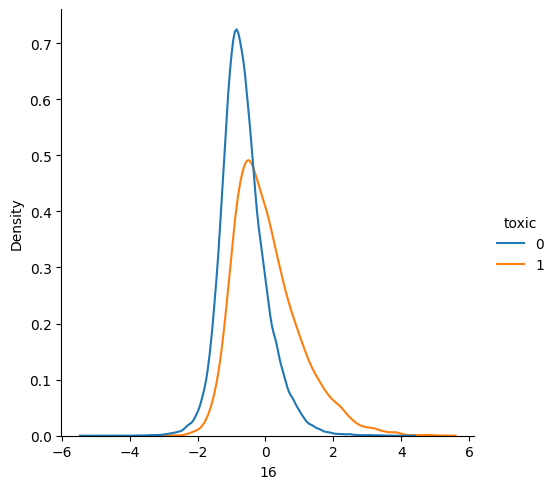

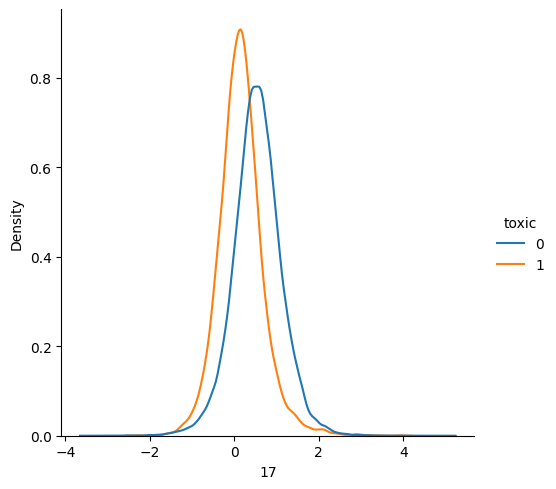

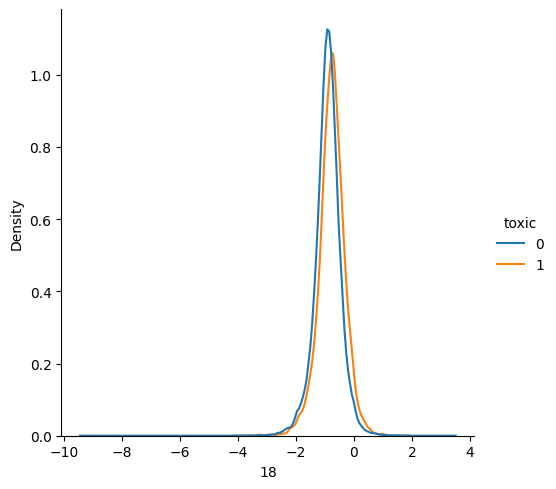

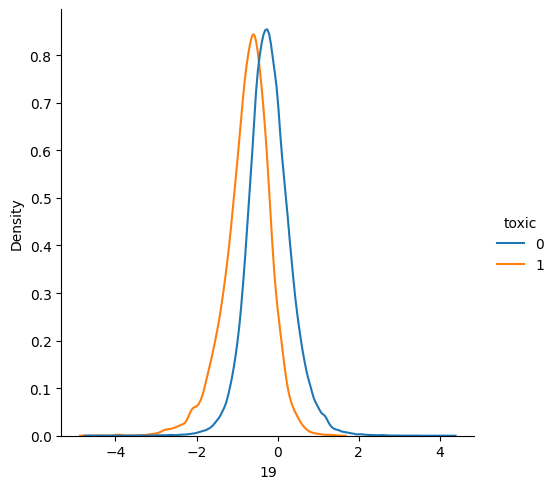

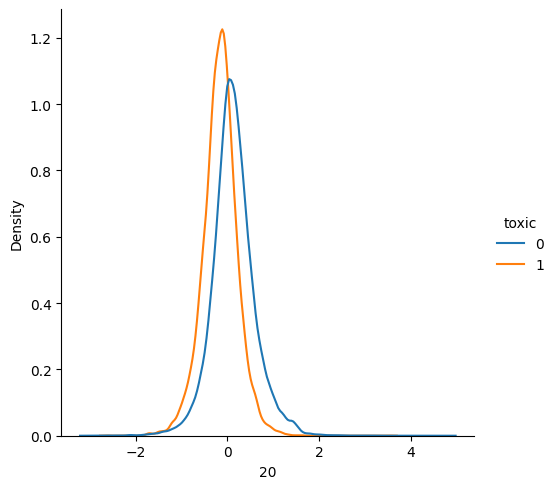

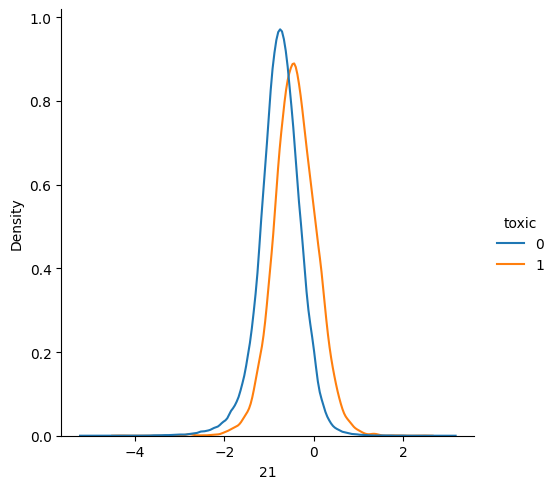

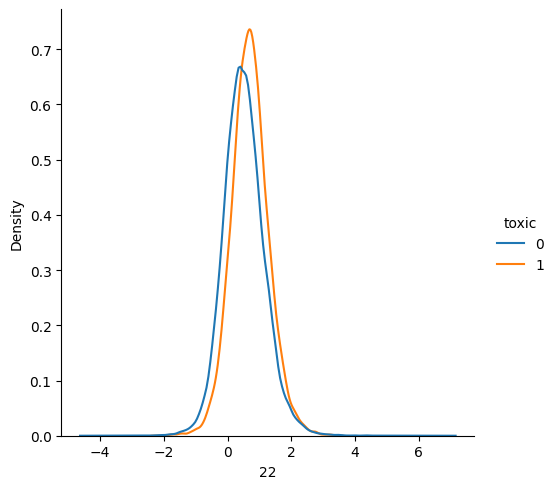

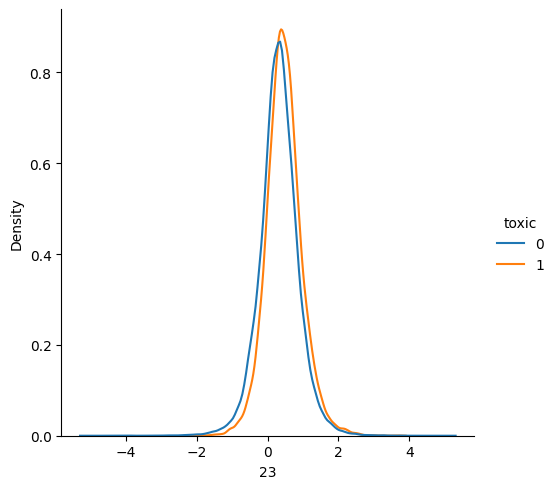

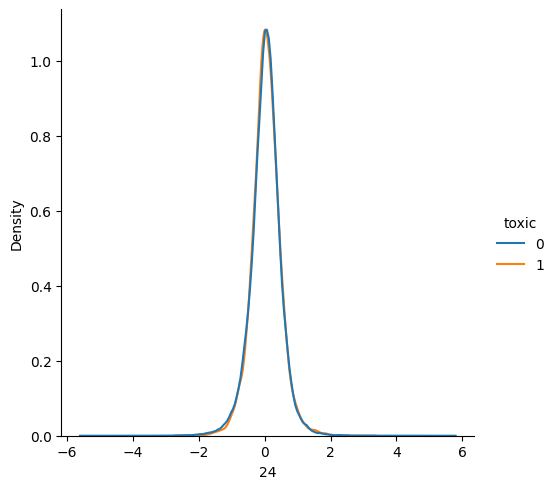

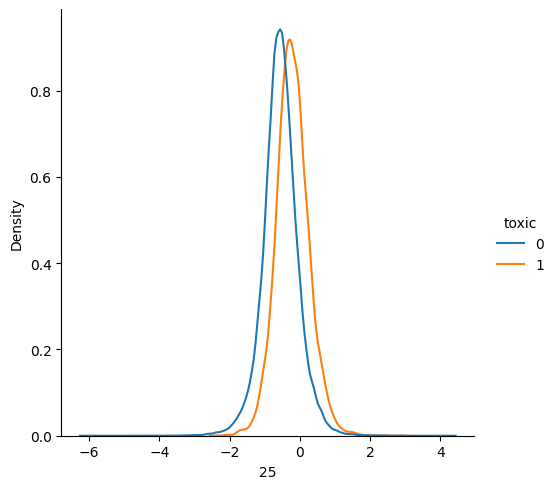

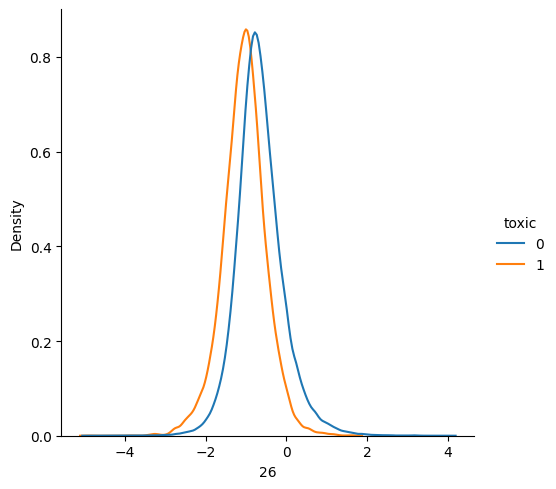

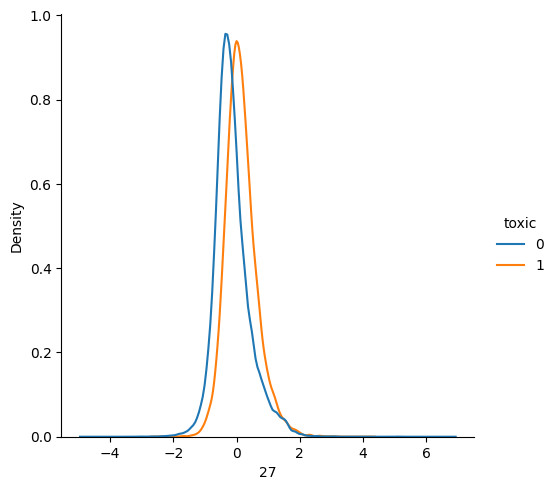

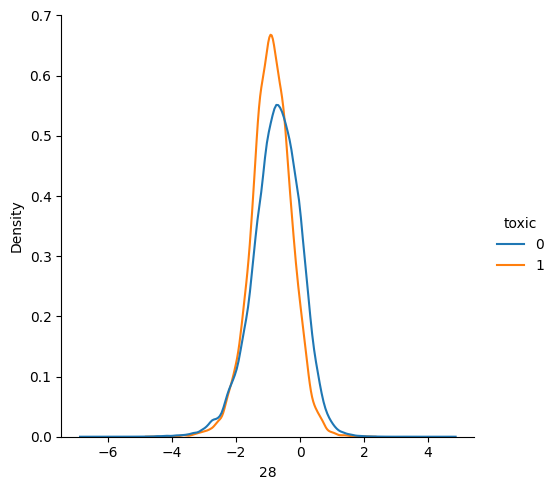

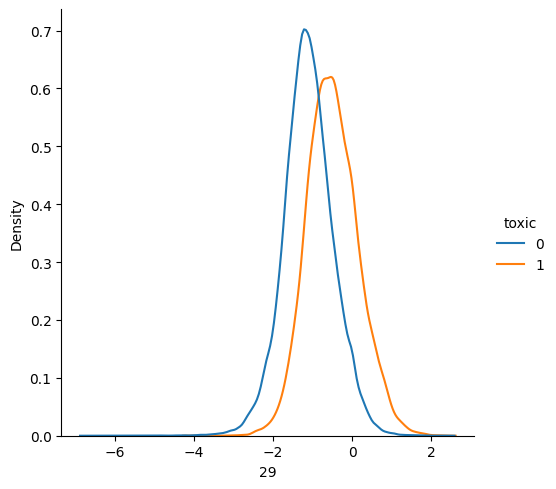

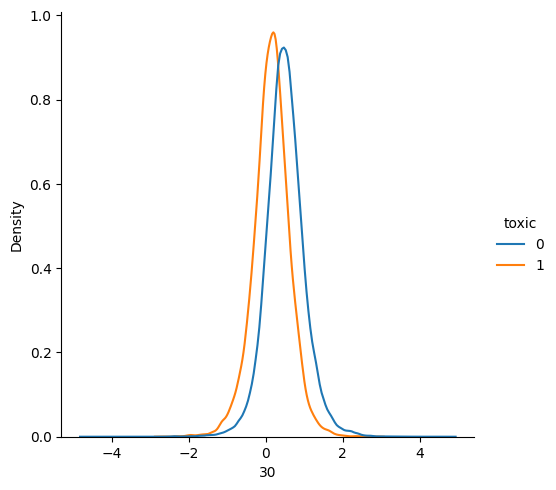

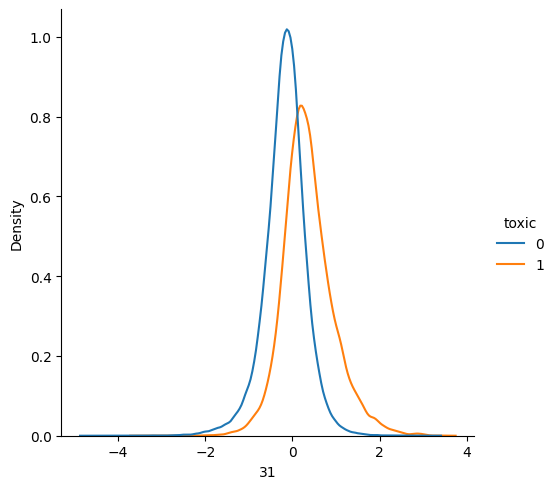

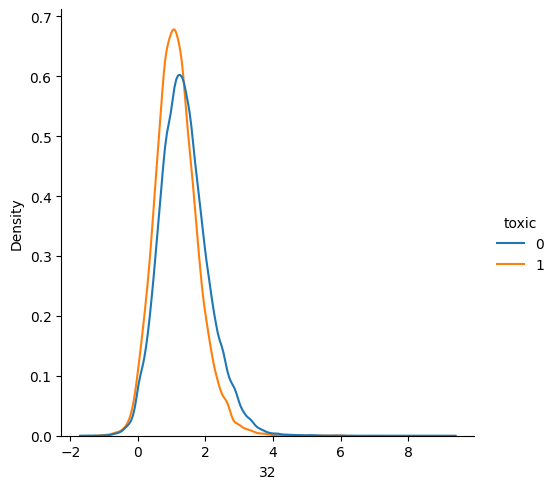

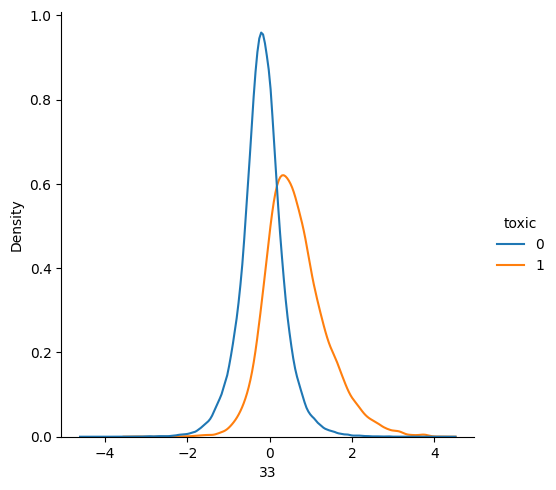

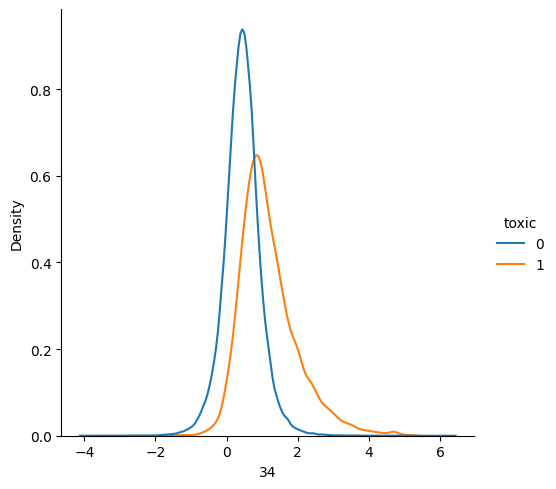

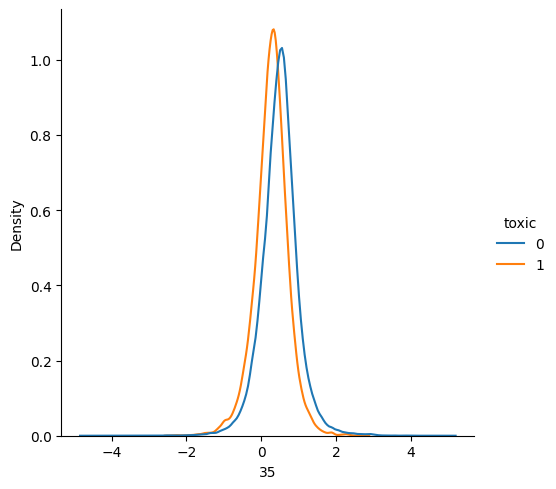

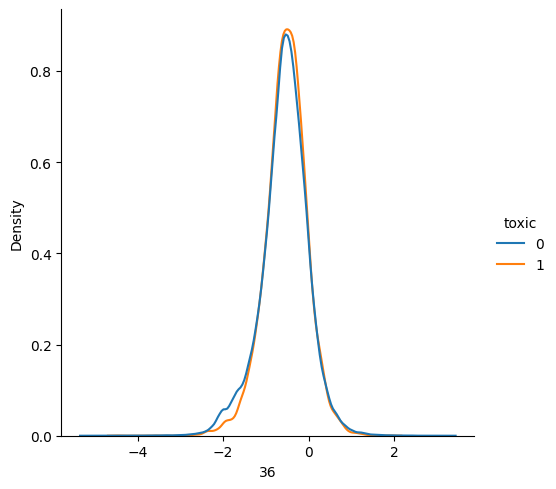

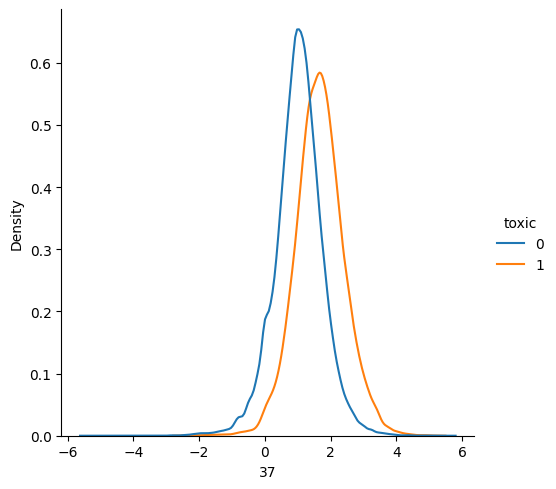

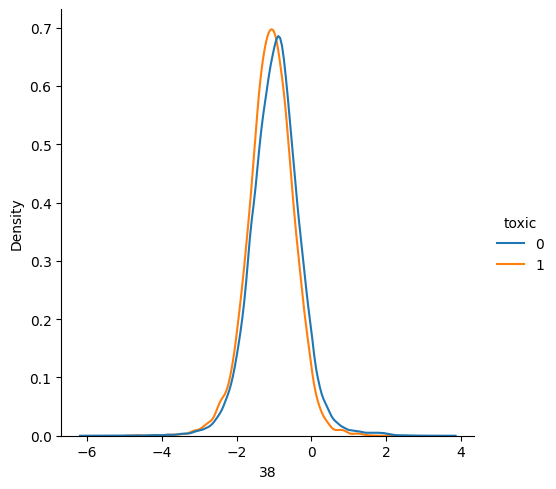

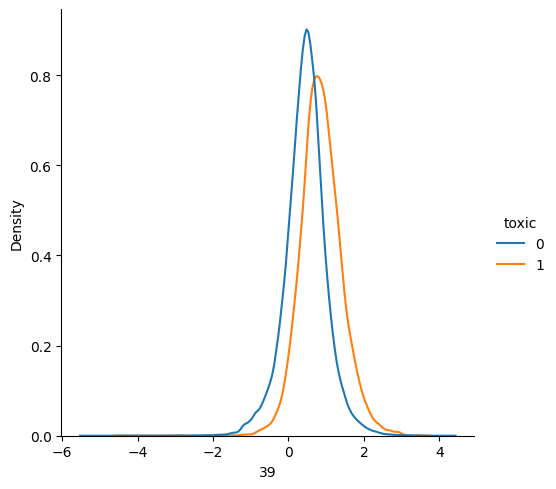

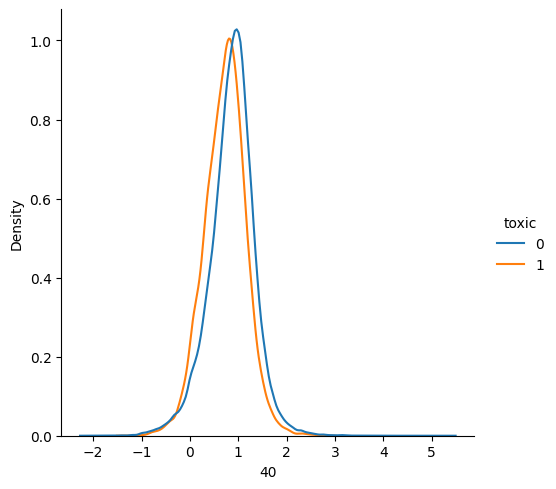

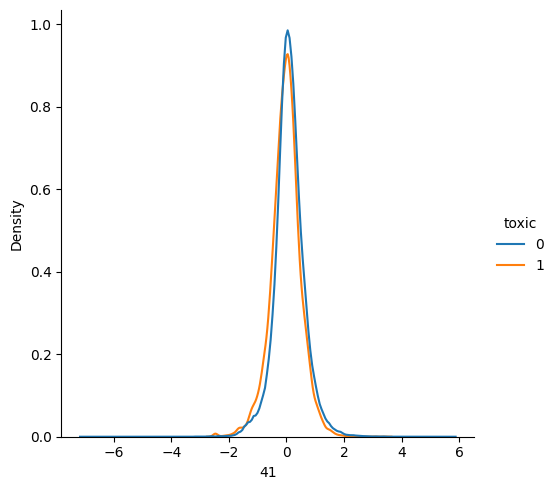

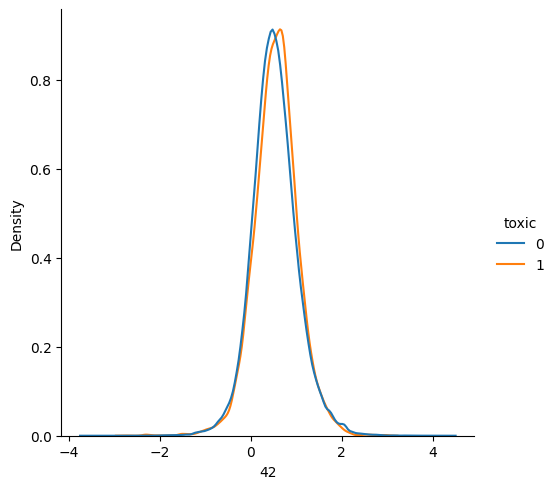

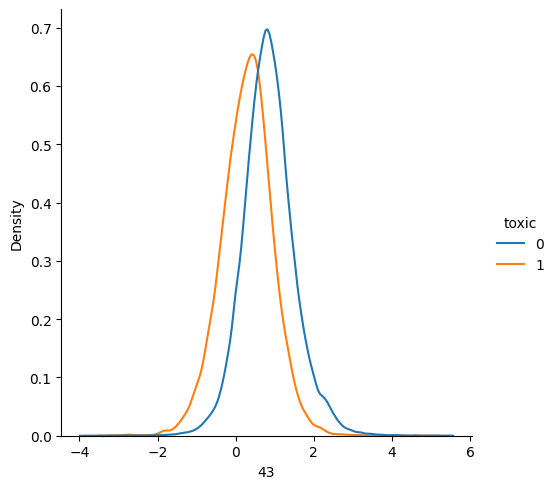

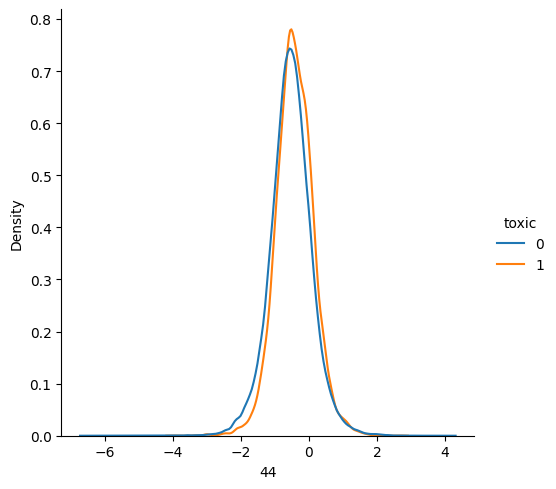

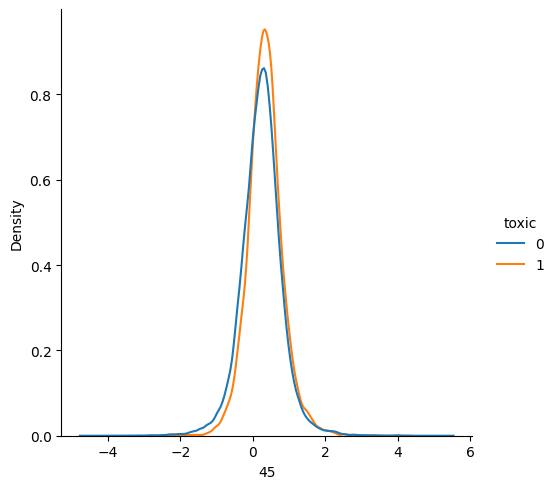

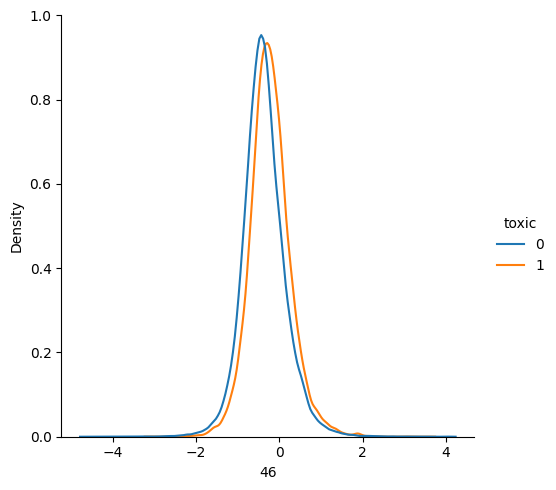

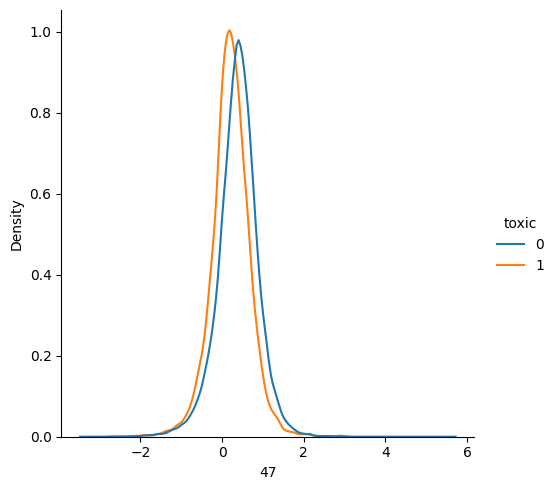

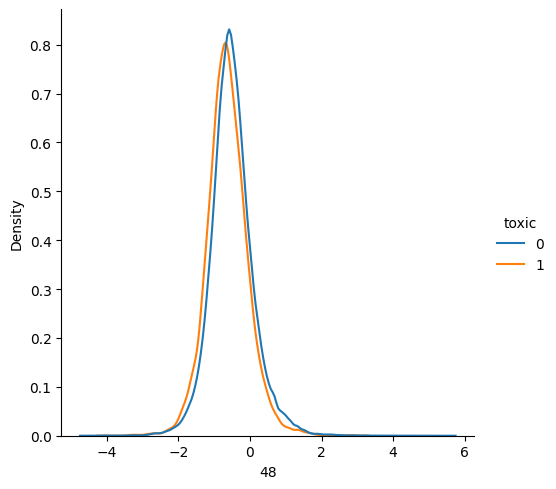

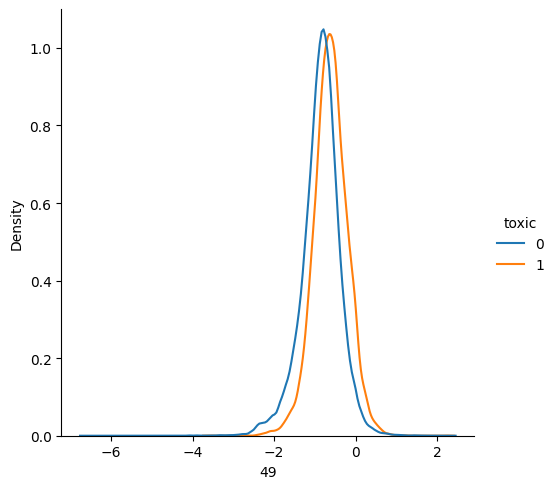

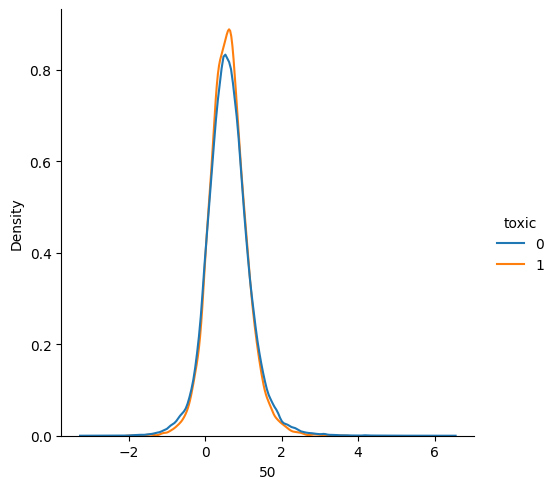

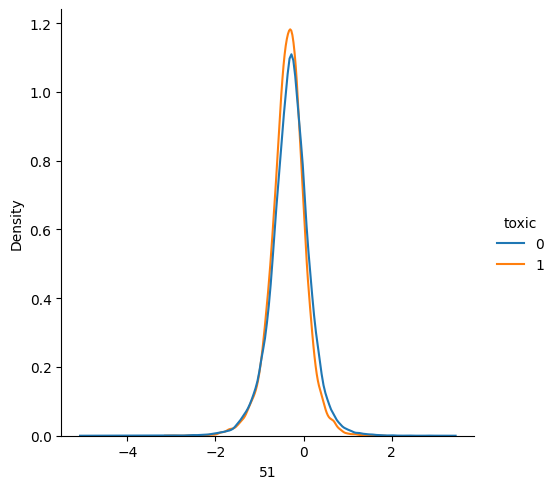

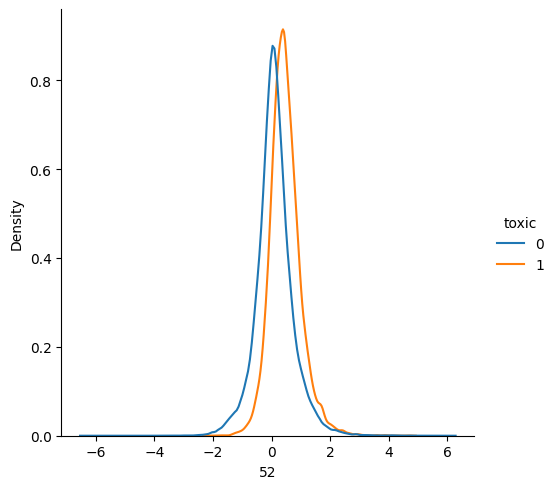

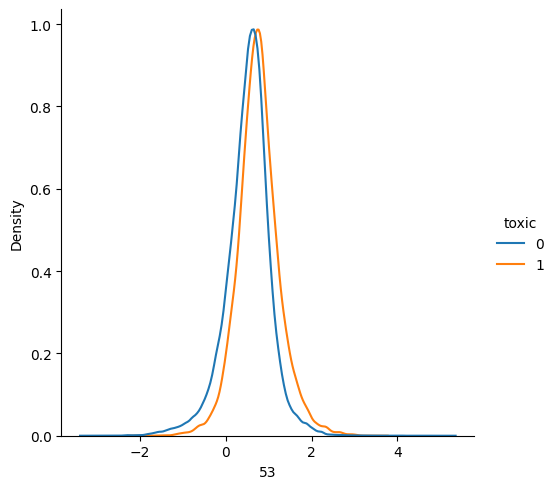

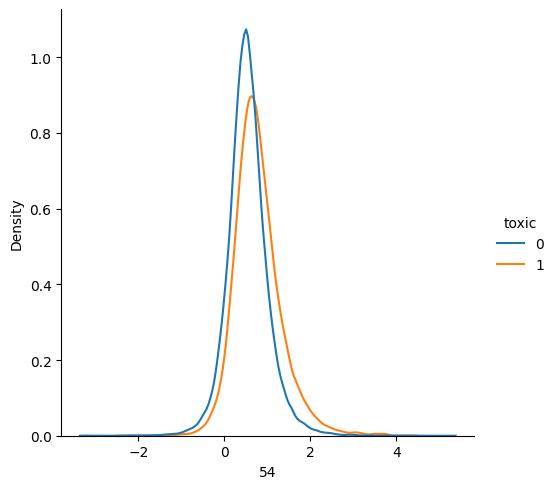

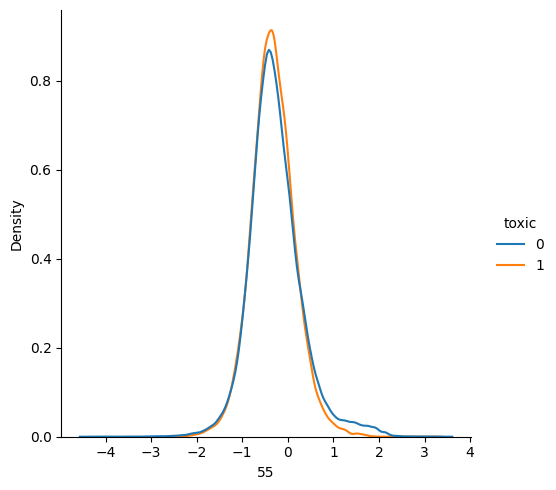

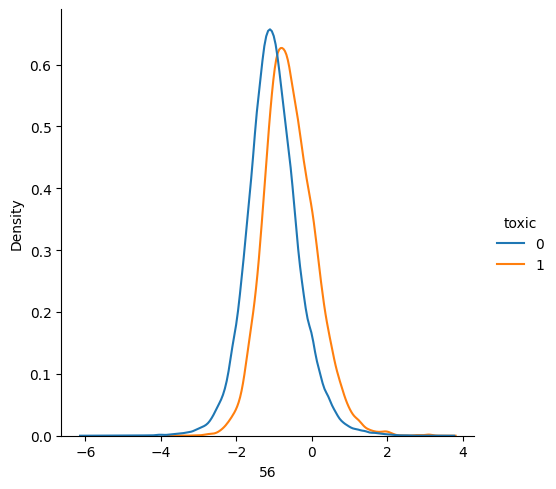

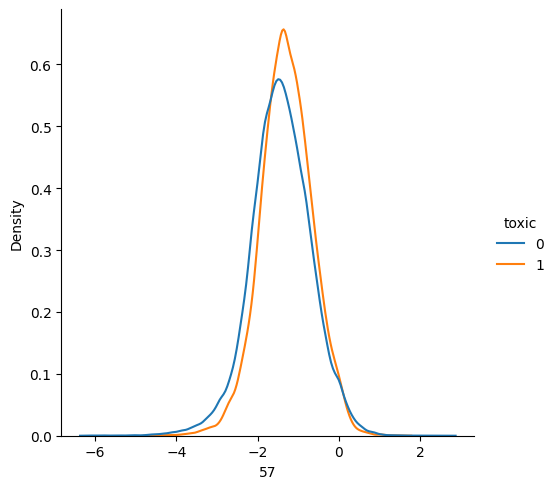

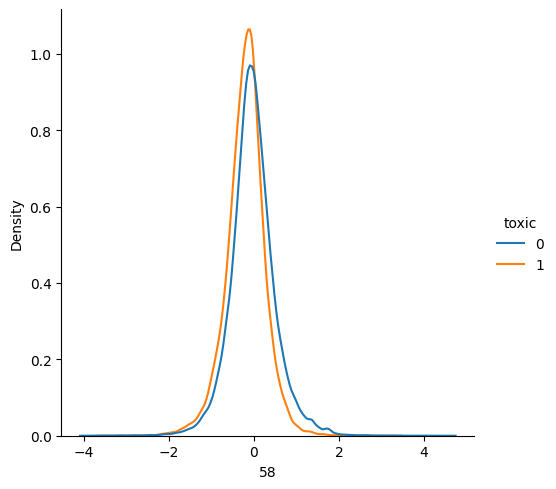

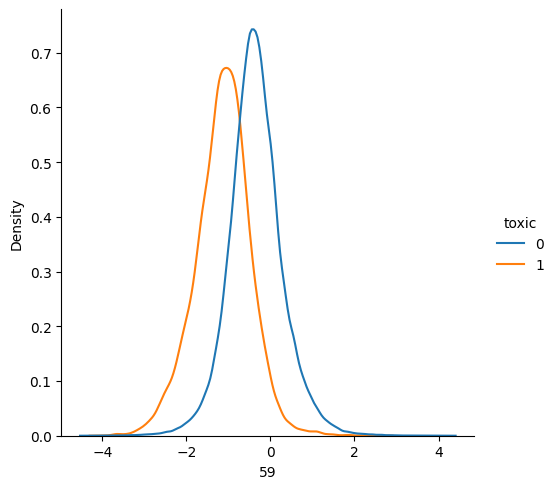

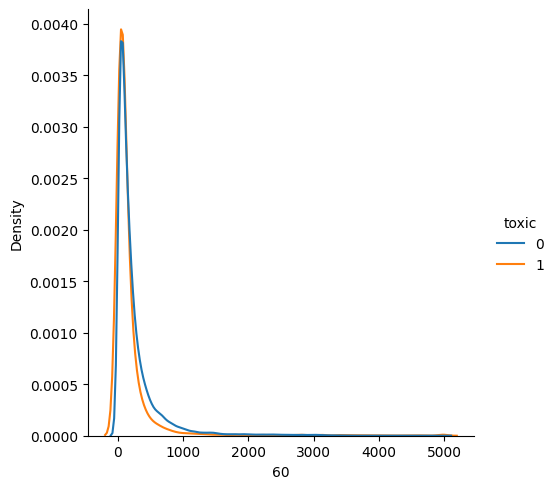

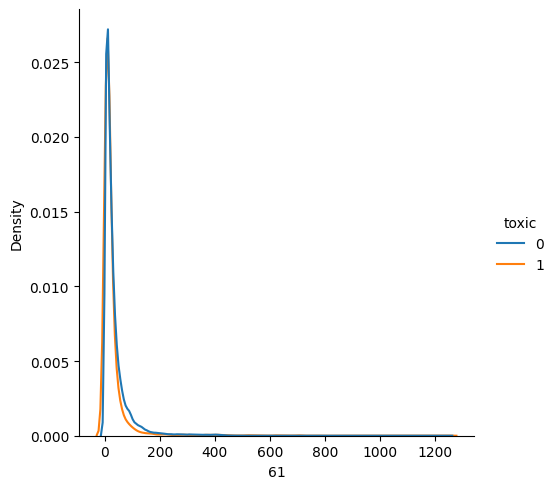

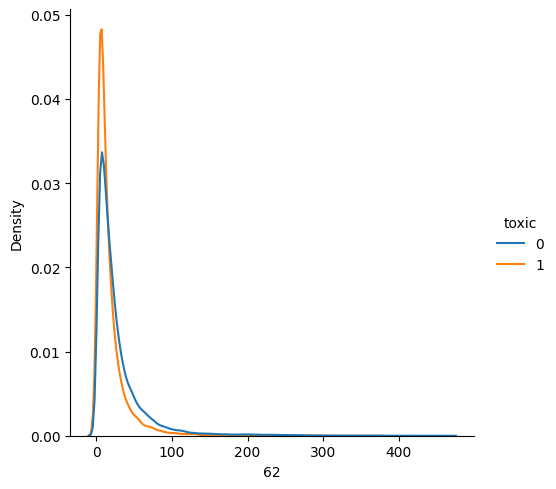

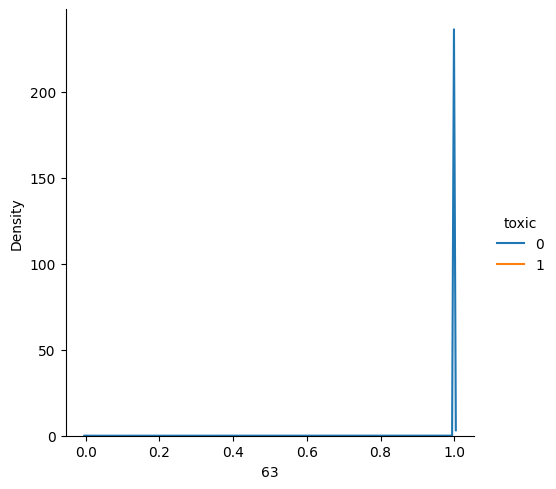

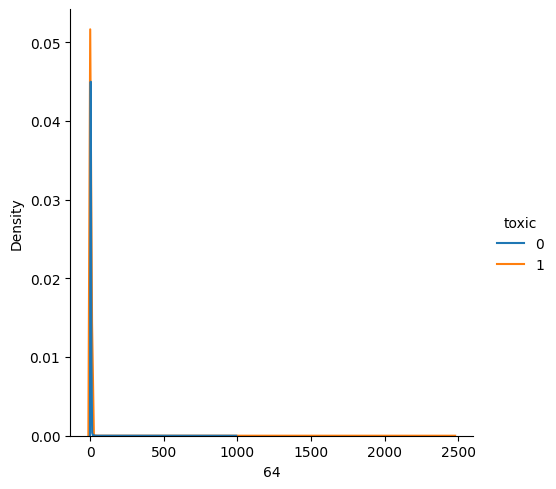

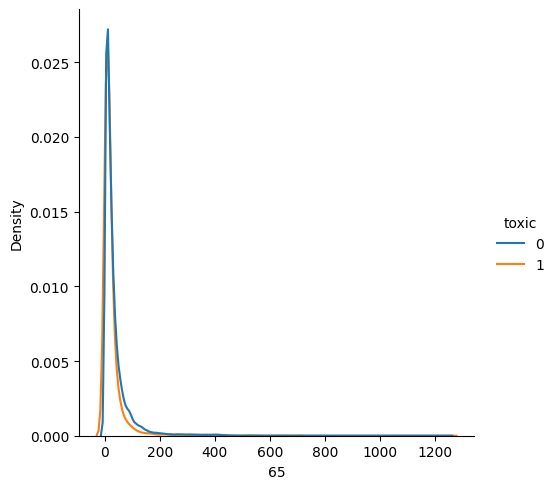

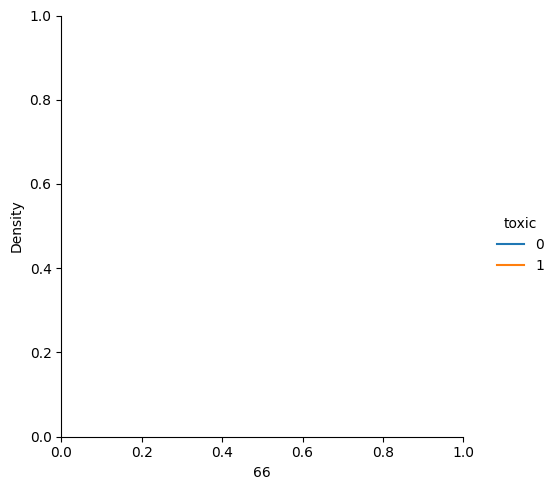

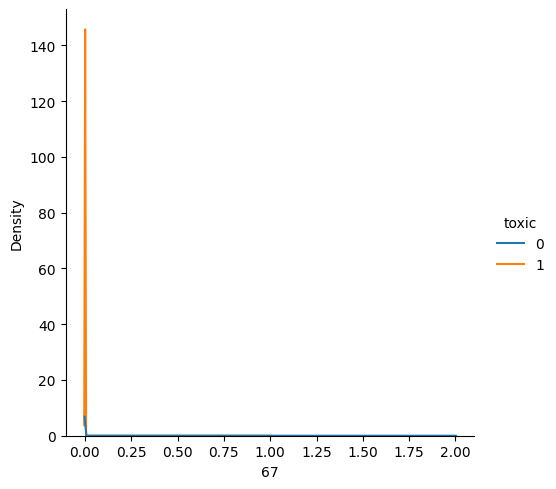

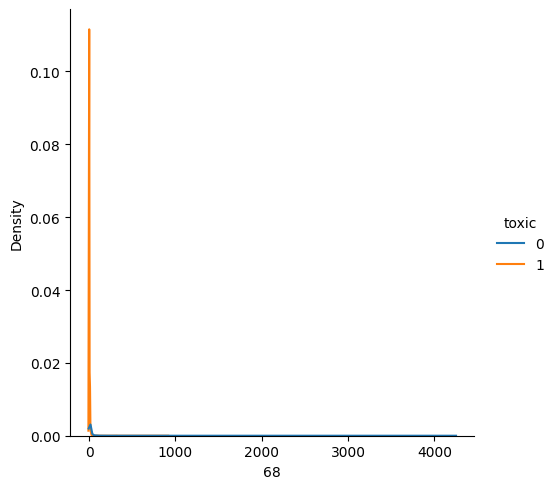

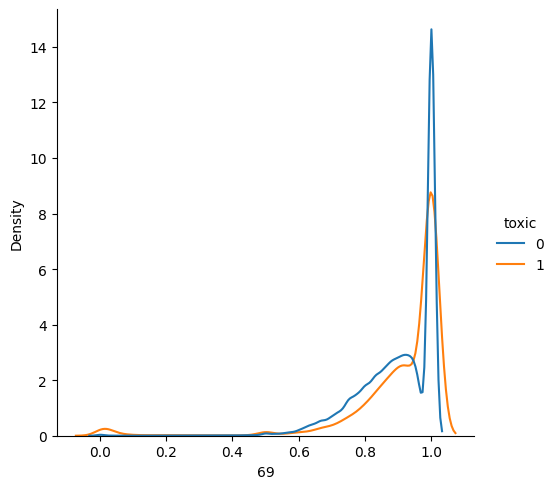

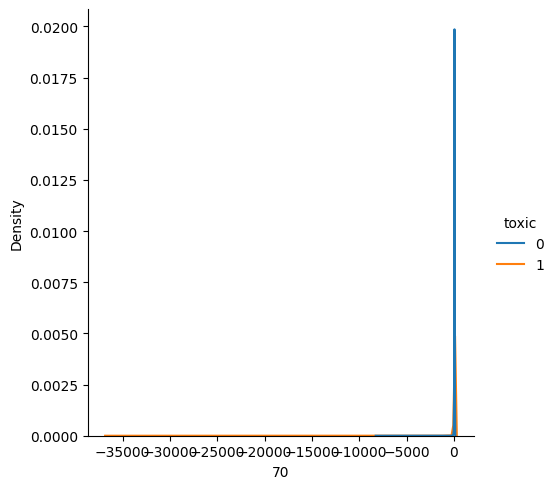

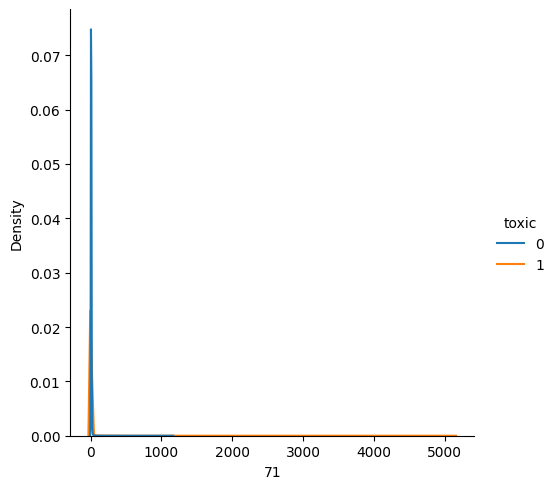

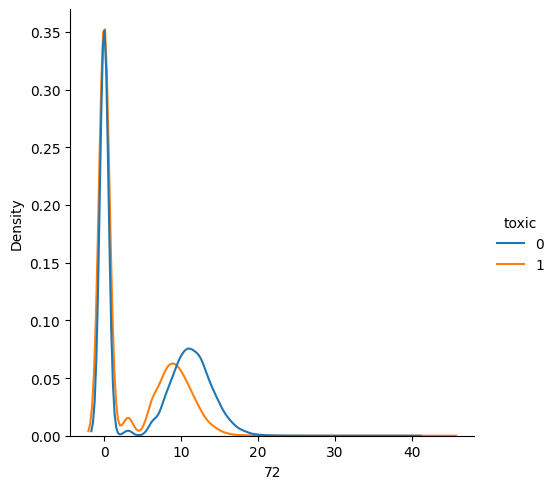

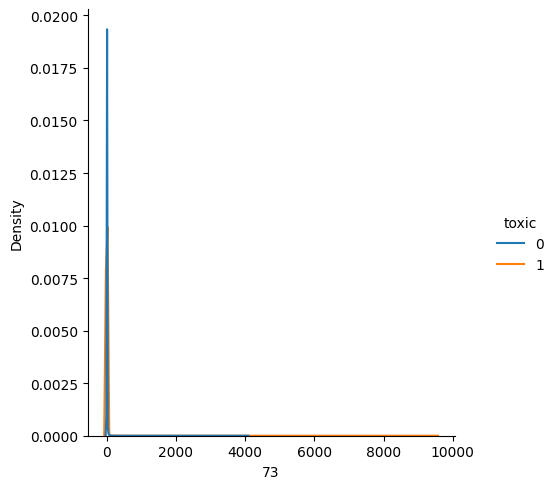

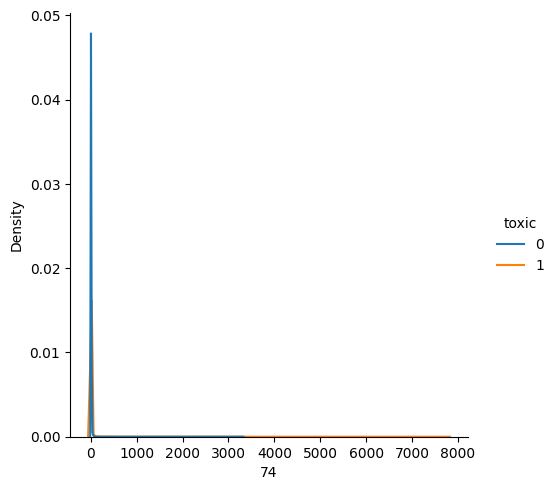

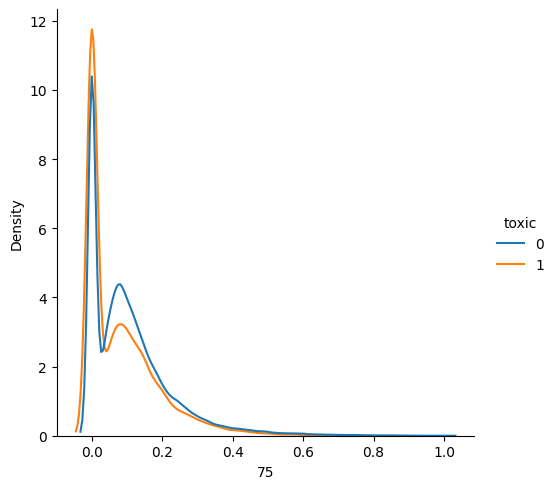

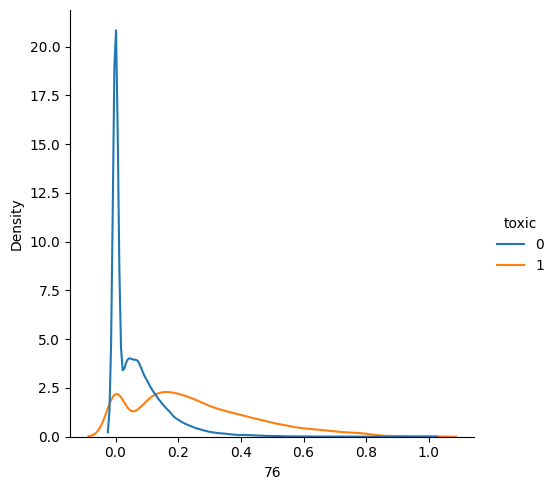

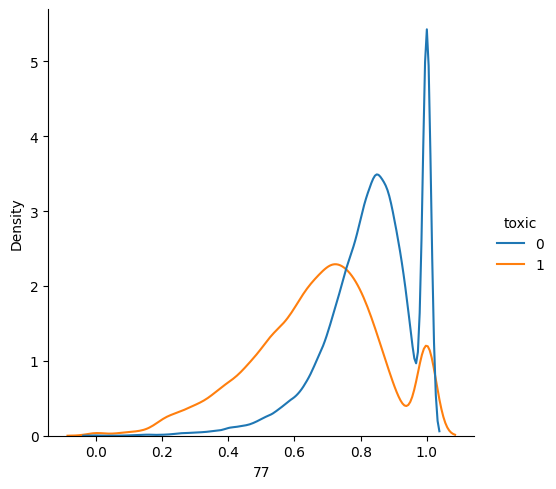

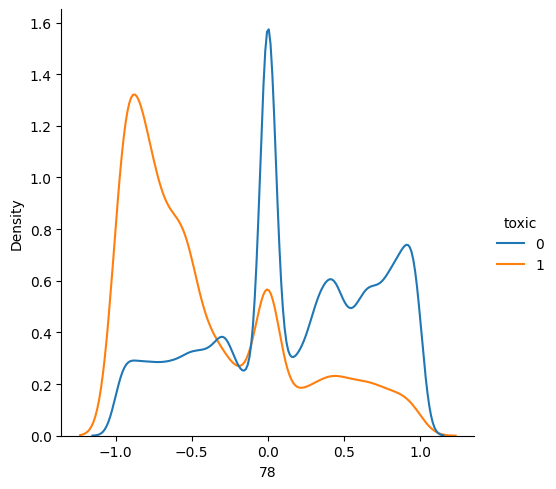

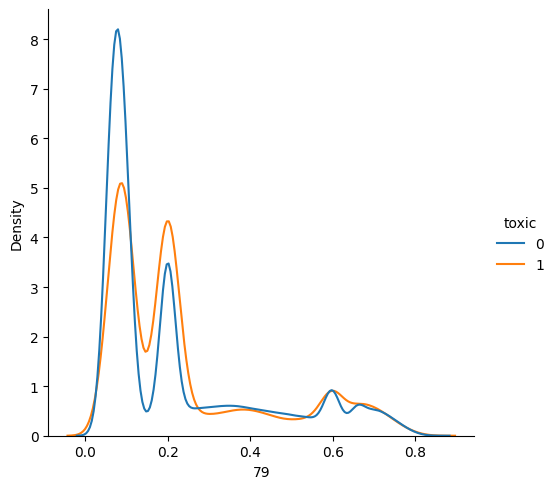

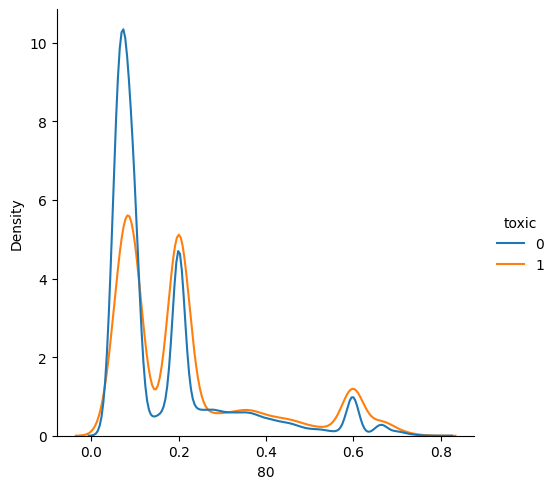

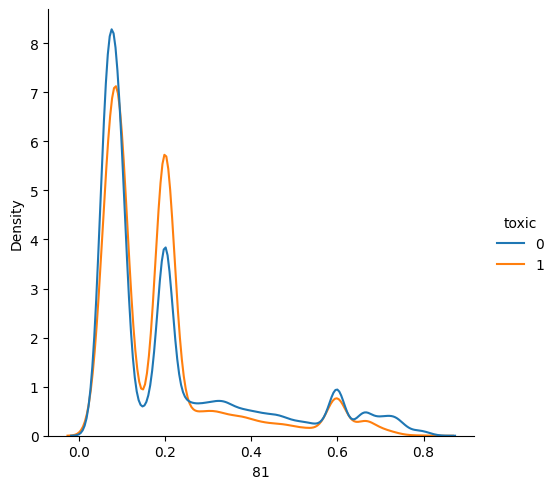

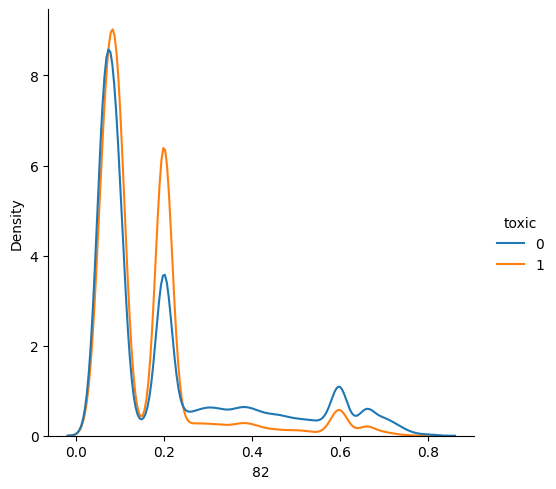

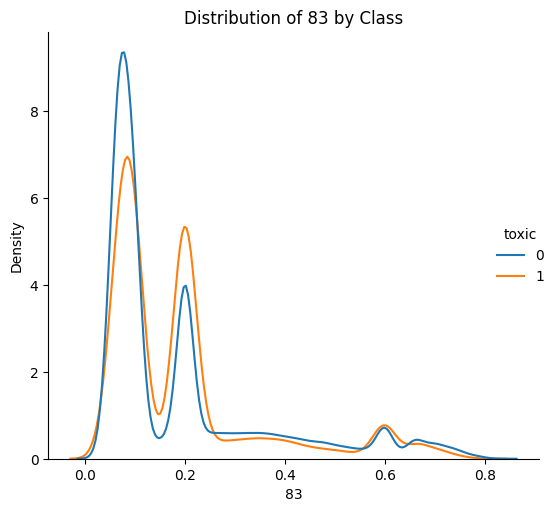

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=17, ncols=5, figsize=(12, 30))
axes = axes.flatten()

for i, feature in enumerate(data.columns):
  sns.displot(data, x=feature, hue=target, kind="kde", common_norm=False, ax=axes[i])

plt.tight_layout()
plt.title(f"Distribution of {feature} by Class")
plt.show()

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

print(data["63"].value_counts())
print(data["66"].value_counts())
print(data["67"].value_counts())

# Plot histogram with KDE
# for feature in data.columns:
  # sns.histplot(data[feature], kde=True)
  # plt.title('Feature Distribution with KDE')
  # plt.show()

63
1.0    159538
0.0        33
Name: count, dtype: int64
66
0.0    159571
Name: count, dtype: int64
67
0.0    159566
1.0         4
2.0         1
Name: count, dtype: int64


# Feature Selection
- create elastic net model
- test hyperparameters
- feature select on best performance

In [20]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [21]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# hyperparameters to check
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.7, 1.0]
}

# model
elasticnet = ElasticNet()
grid_search = GridSearchCV(estimator=elasticnet, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']
best_model = grid_search.best_estimator_
print(f"Best alpha: {best_alpha}, Best l1_ratio: {best_l1_ratio}")

# test best model
y_pred = best_model.predict(X_test)
print(f"Test MSE: {mean_squared_error(y_test, y_pred)}")

print("Best Model Coefficients: ", best_model.coef_)
print("Near zero coefficients can be culled. ")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
# values below threshhold will be cut from the dataset
threshold_value = 0.01
cull_cols = np.abs(best_model.coef_) < threshold_value
# print (cull_cols)
new_data = data.iloc[:, ~cull_cols]

# new_data.describe()
new_data.shape